In [2]:
import os
import pickle
import numpy as np
import random
from scipy.ndimage import uniform_filter1d, gaussian_filter1d
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeriesClassifier, \
    KNeighborsTimeSeries
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

/home/tyler/.local/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [16]:
training_directory = '/home/tyler/Documents/Matt3r/imu-classification/DATA/standardized/stage5_standartized/train'
validation_directory = '/home/tyler/Documents/Matt3r/imu-classification/DATA/standardized/stage5_standartized/val'

TRAIN_SAMPLES_PER_CLASS = 100
VAL_SAMPLES_PER_CLASS = 100
NUM_CLUSTERS = [100,100,100,100,100,100]

def shuffle_data_set(X, Y=None, size=None):
    indices = list(range(len(X)))
    random.shuffle(indices)
    shuffled_X = [X[i] for i in indices][:size]
    if Y is not None:
        shuffled_Y = [Y[i] for i in indices][:size]
        return shuffled_X, shuffled_Y
    else: return shuffled_X

def compute_clusters(X, num_clusters):
    km = TimeSeriesKMeans(num_clusters, metric="dtw")
    km.fit(X)
    return km.cluster_centers_

# collect data for either training or validation
def get_data(folder_path, n_samples, n_clusters=None, train=False):
    num_classes = 0
    X = []
    Y = []
    labels = []
    for id, folder in enumerate(os.listdir(folder_path)):
        if id in [0,1,2,3,4,5]:
            labels.append(folder)
            folder_list = []
            for file_name in os.listdir(os.path.join(folder_path, folder)):
                if file_name.endswith(".npy"):
                    file_path = os.path.join(folder_path, folder, file_name)
                    data = np.load(file_path, allow_pickle=True)
                    folder_list.append(data[[0,2],:].T)
            if train:
                train_set = to_time_series_dataset(shuffle_data_set(folder_list, size=n_samples))
                clusters = compute_clusters(train_set, n_clusters[id])
                X.append(clusters)
                Y += [id] * n_clusters[id]
            else:
                X += shuffle_data_set(folder_list, size=n_samples)
                Y += [id] * n_samples
        if id >= num_classes:
            num_classes += 1
    if train:
        X_ts = np.concatenate(X, axis=0)
    else:
        X_ts = to_time_series_dataset(X)
    # shuffle the datasets
    # X_shuffled, Y_shuffled = shuffle_data_set(X, Y, n_samples * num_classes)
    X_shuffled, Y_shuffled = X_ts, Y
    return X_shuffled, np.array(Y_shuffled), labels

ts_X_train, ts_Y_train, class_labels = get_data(validation_directory, TRAIN_SAMPLES_PER_CLASS, NUM_CLUSTERS, train=True)
ts_X_val, ts_Y_val, _ = get_data(training_directory, VAL_SAMPLES_PER_CLASS)

In [8]:
ts_X_train.reshape(ts_X_train.shape[0], -1).shape

(600, 150)

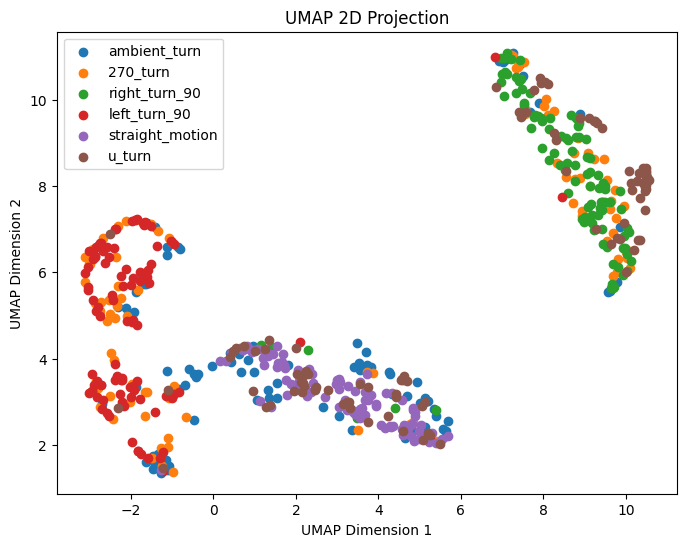

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP

# Generate example data
np.random.seed(42)
# data = np.random.rand(50, 10)  # Your data of shape (50, n_features)
# labels = np.random.randint(0, 6, size=50)  # Labels for the 6 classes
data = ts_X_train.reshape(ts_X_train.shape[0], -1)
labels = ts_Y_train

# Apply UMAP for dimensionality reduction
umap = UMAP(n_components=2, random_state=42)
reduced_data = umap.fit_transform(data)

# Create a scatter plot
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(class_labels):
    plt.scatter(
        reduced_data[labels == i, 0],
        reduced_data[labels == i, 1],
        label=f'{class_label}',
    )

plt.title("UMAP 2D Projection")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.show()